# 导包

In [26]:
# 导包
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 导入文件,查看数据信息

In [28]:
#导入文件,查看前五行
data=pd.read_csv('Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [29]:
#查看数据整体信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [30]:
#查看是否有重复值
data.duplicated().sum()

0

# 描述性统计

In [31]:
#区分离散型和连续型变量
categorical_features = ['Channel','Region']
continuous_features = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

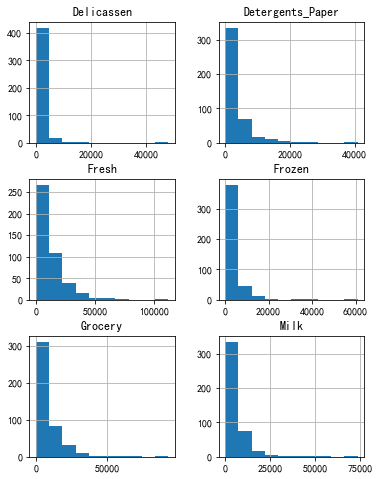

In [32]:
data[continuous_features].hist(figsize=(6,8));

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


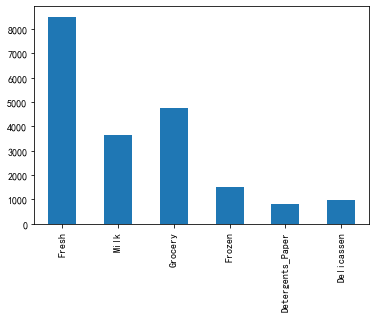

In [33]:
#描述性统计,发现数据呈右偏态分布,根据中位数,对各类商品排序,Fresh>Grocery>Milk>Frozen>Delicassen>Detergents_Paper

data[continuous_features].describe().loc['50%',:].plot.bar()

data[continuous_features].describe()


# 查看异常值并剔除

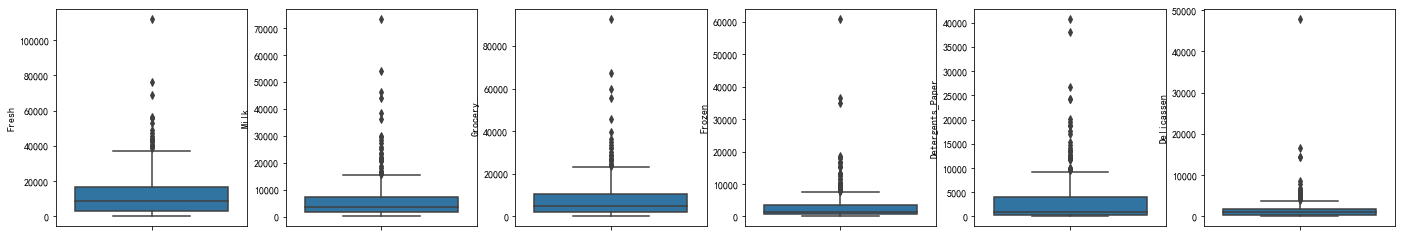

In [34]:
#查看异常值

def get_boxplot(data, start, end):
    fig, ax = plt.subplots(1, end-start, figsize=(24, 4))
    for i in range(start, end):
        sns.boxplot(y=data[data.columns[i]], data=data, ax=ax[i-start])
get_boxplot(data, 2, 8)

#可以看到以上6个连续型变量均有不同程度的异常值, 由于k-means算法对异常值较敏感, 因此选择剔除它

原有样本容量:440, 剔除后样本容量:340


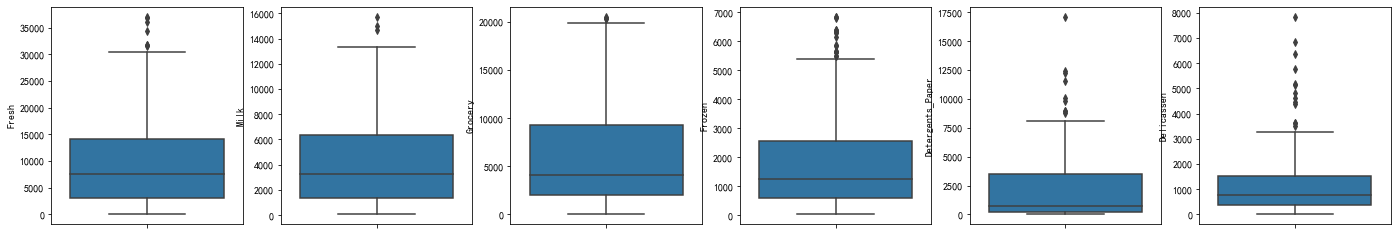

In [35]:
#将数据中偏大,偏小的'异常数据'过滤掉, 四分位距 IQR, 下四分位Q1-1.5IQR得到最小值,上四分位 Q3+1.5IQR得到最大值

def drop_outlier(data, start, end):
    for i in range(start, end):
        field = data.columns[i]
        Q1 = np.quantile(data[field], 0.25)
        Q3 = np.quantile(data[field], 0.75)
        IQR = (Q3 - Q1) * 1.5
        data = data[(data[field] >= Q1 - IQR) & (data[field] <= Q3 + IQR)]
    return data
del_data = drop_outlier(data, 0, 6)
print("原有样本容量:{0}, 剔除后样本容量:{1}".format(data.shape[0], del_data.shape[0]))
get_boxplot(del_data, 2, 8)


In [36]:
# 删除之后重置索引
del_data.reset_index(drop=True,inplace=True)
del_data

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
335,1,3,21117,1162,4754,269,1328,395
336,1,3,1982,3218,1493,1541,356,1449
337,1,3,16731,3922,7994,688,2371,838
338,1,3,10290,1981,2232,1038,168,2125


# 连续变量去量纲

In [37]:
#去量纲
mms = StandardScaler()
# mms=MinMaxScaler()
mms.fit(del_data[continuous_features])
del_data_mms = mms.transform(del_data[continuous_features])
del_data_mms=pd.DataFrame(del_data_mms,columns=data[continuous_features].columns)
del_data_mms

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.366509,1.580604,0.323804,-0.996070,0.216738,0.174192
1,-0.314705,1.625484,0.728257,-0.022327,0.450050,0.561366
2,-0.400160,1.333474,0.348591,0.382141,0.534102,5.925226
3,0.438855,-0.884864,-0.349276,2.897644,-0.600041,0.571973
4,1.573808,0.343207,0.250652,1.331981,-0.121356,3.574780
...,...,...,...,...,...,...
335,1.391972,-0.894773,-0.241865,-0.961473,-0.290592,-0.659381
336,-0.930735,-0.295600,-0.899025,-0.161343,-0.656955,0.272311
337,0.859576,-0.090436,0.411063,-0.697908,0.102532,-0.267787
338,0.077734,-0.656095,-0.750101,-0.477747,-0.727815,0.869867


# 分类变量独热编码

In [38]:
# 数据预处理，进行独热编码
from sklearn.preprocessing import OneHotEncoder
data_cate= del_data[categorical_features]
# data_onehot = OneHotEncoder().fit_transform(data).toarray()

onehot = OneHotEncoder().fit(data_cate)
data_onehot = onehot.transform(data_cate).toarray()
# data_onehot

In [39]:
#对独热编码生成的特征进行命名
colnames=[]
features = np.array(categorical_features)
features = np.array([i + '_' for i in features])
onehot_category=onehot.categories_
for i in range(len(onehot.categories_)):
    onehot_category[i]=onehot.categories_[i].astype('str')
    for j in range(len(onehot_category[i])):
        colnames.append(features[i]+onehot_category[i][j])
colnames
# np.array(onehot_category)

['Channel_1', 'Channel_2', 'Region_1', 'Region_2', 'Region_3']

In [249]:
# features = np.array(categorical_features)
# features = np.array([i + '_' for i in features])
# one_hot_features = np.array(onehot_category)
# colnames = np.append(*features + one_hot_features)

In [70]:
# colnames=['Channel_1','Channel_2','Region_1','Region_2','Region_3']

In [40]:
# 将onehot_result做成dataframe，并且添加上列名
one_hot_df = pd.DataFrame(data_onehot, columns = colnames)

# 用pd.concat将标准化后的连续变量和独热编码进行拼接
data_new = pd.concat([del_data_mms, one_hot_df], axis = 1)
data_new

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,0.366509,1.580604,0.323804,-0.996070,0.216738,0.174192,0.0,1.0,0.0,0.0,1.0
1,-0.314705,1.625484,0.728257,-0.022327,0.450050,0.561366,0.0,1.0,0.0,0.0,1.0
2,-0.400160,1.333474,0.348591,0.382141,0.534102,5.925226,0.0,1.0,0.0,0.0,1.0
3,0.438855,-0.884864,-0.349276,2.897644,-0.600041,0.571973,1.0,0.0,0.0,0.0,1.0
4,1.573808,0.343207,0.250652,1.331981,-0.121356,3.574780,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
335,1.391972,-0.894773,-0.241865,-0.961473,-0.290592,-0.659381,1.0,0.0,0.0,0.0,1.0
336,-0.930735,-0.295600,-0.899025,-0.161343,-0.656955,0.272311,1.0,0.0,0.0,0.0,1.0
337,0.859576,-0.090436,0.411063,-0.697908,0.102532,-0.267787,1.0,0.0,0.0,0.0,1.0
338,0.077734,-0.656095,-0.750101,-0.477747,-0.727815,0.869867,1.0,0.0,0.0,0.0,1.0


In [48]:
# scaler_data=pd.DataFrame(data_transformed)
# scaler_data.columns=['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen','Channel_1','Channel_2','Region_1','Region_2','Region_3']
# scaler_data.head()

# 训练模型并评估

In [41]:
#比较不同K值下的SSE
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    
    km = KMeans(n_clusters=k)
    km = km.fit(data_new)
    Sum_of_squared_distances.append(km.inertia_)

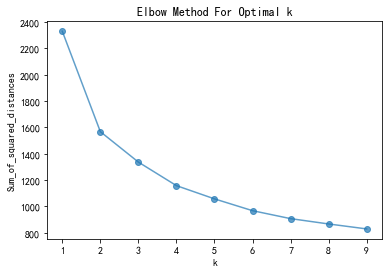

In [42]:
#学习曲线, 找到最优的K值

plt.plot(K, Sum_of_squared_distances,'-o', alpha=0.7)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#通过曲线的形状,大概判断最优K值应该为2,3,4中的一个,用轮廓系数进一步判断

In [51]:
km.labels_

array([6, 6, 6, 8, 6, 6, 6, 6, 1, 2, 2, 6, 6, 2, 6, 1, 2, 1, 6, 1, 6, 8,
       6, 6, 8, 1, 5, 1, 5, 5, 1, 6, 5, 2, 2, 5, 2, 6, 6, 8, 1, 2, 5, 1,
       2, 1, 1, 6, 6, 2, 8, 1, 6, 8, 1, 6, 8, 1, 1, 1, 2, 6, 5, 6, 5, 8,
       2, 1, 6, 1, 1, 8, 2, 2, 6, 1, 1, 6, 2, 6, 1, 2, 8, 5, 8, 1, 1, 8,
       8, 5, 1, 1, 6, 5, 6, 1, 8, 1, 1, 1, 1, 1, 8, 1, 1, 1, 5, 5, 5, 1,
       1, 1, 8, 5, 1, 1, 5, 1, 1, 2, 2, 8, 6, 2, 6, 1, 5, 6, 2, 6, 1, 1,
       1, 2, 1, 2, 1, 6, 5, 1, 8, 1, 1, 1, 1, 8, 8, 2, 2, 1, 1, 2, 1, 7,
       3, 3, 3, 3, 3, 3, 7, 3, 7, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 7, 3, 3,
       7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 7, 3, 3, 3, 3, 5, 1, 1, 5, 8, 6, 1,
       6, 1, 1, 1, 1, 8, 4, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 0, 0, 0, 4,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 6, 1, 1,
       1, 2, 6, 1, 2, 1, 1, 8, 1, 5, 1, 5, 1, 1, 1, 1, 6, 1, 1, 5, 1, 1,
       6, 1, 1, 2, 1, 6, 5, 5, 8, 8, 1, 5, 1, 8, 8,

For n_clusters = 2 The average silhouette_score is : 0.3379413181380951
For n_clusters = 3 The average silhouette_score is : 0.23299200392437958
For n_clusters = 4 The average silhouette_score is : 0.2402071779687975
For n_clusters = 5 The average silhouette_score is : 0.24602903012595986
For n_clusters = 6 The average silhouette_score is : 0.22606857519168663
For n_clusters = 7 The average silhouette_score is : 0.21911105106137344


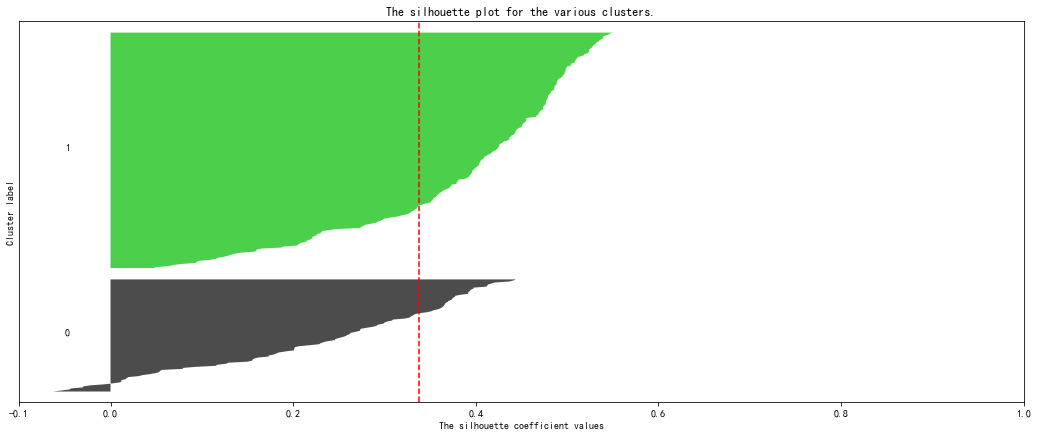

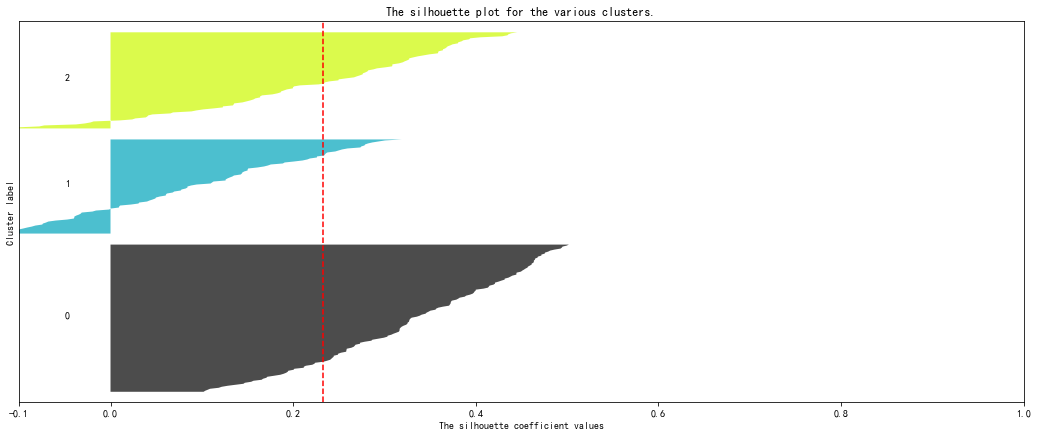

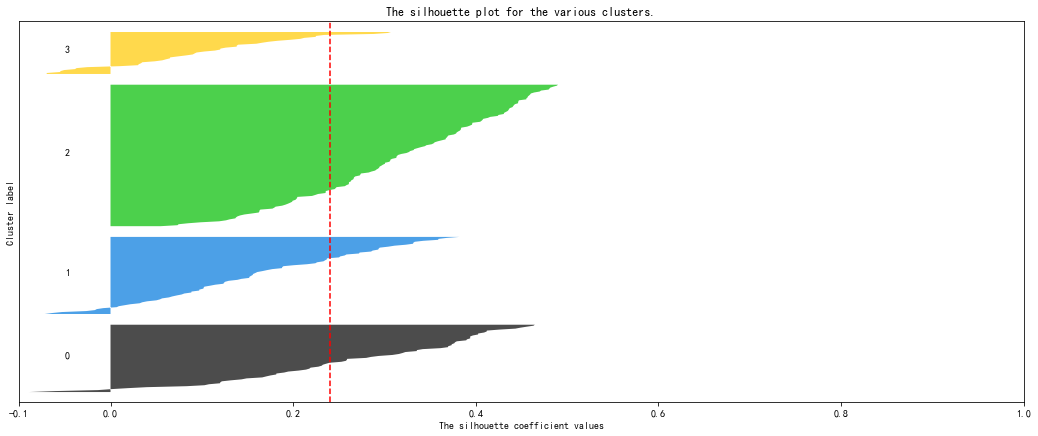

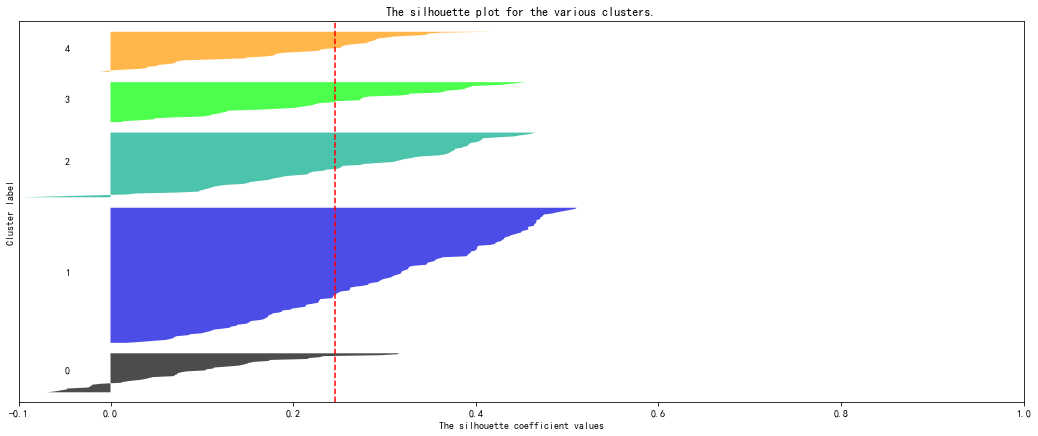

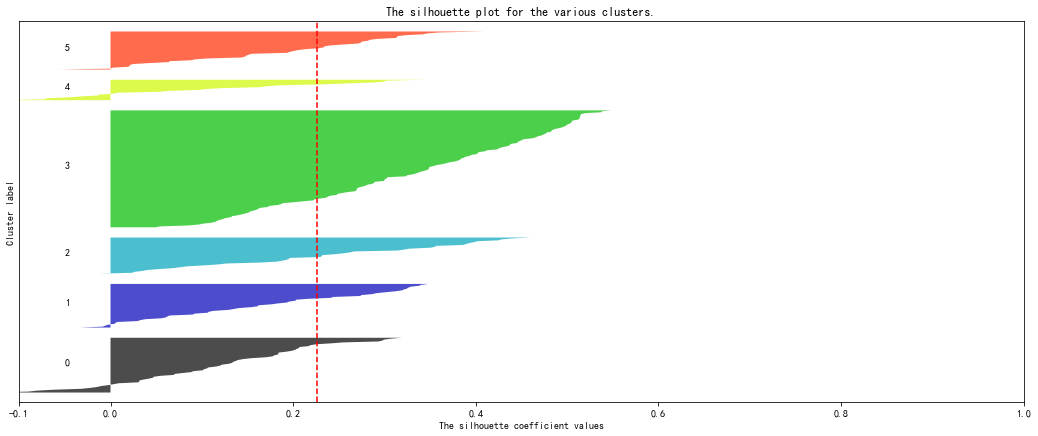

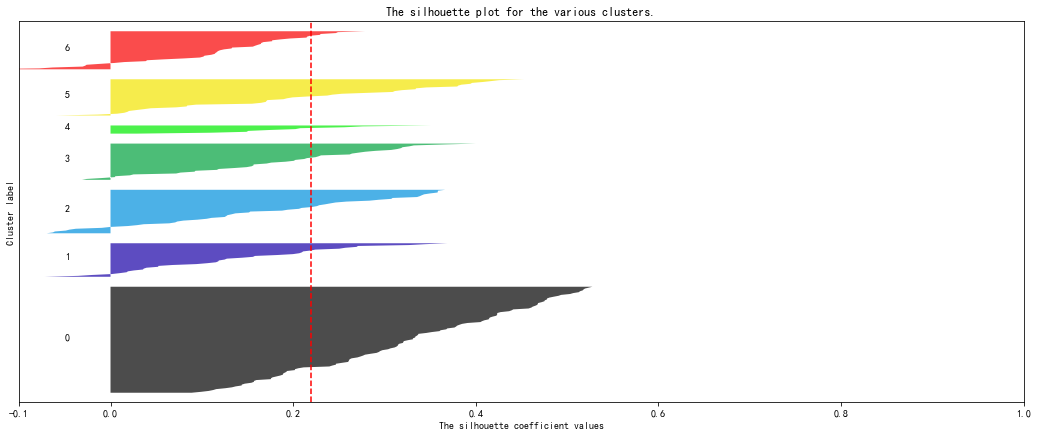

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#先设定我们要分成的簇数,将k的值设置成2—7查看轮廓系数
for n_clusters in [2,3,4,5,6,7]:
#     k=2
#     n_clusters = k
    km = KMeans(n_clusters=n_clusters)
    km = km.fit(data_new)

    plt.figure(figsize=(18,7))
    # fig, ax1 = plt.subplots()
    # fig.set_size_inches(18, 7)

    plt.xlim([-0.1, 1])
    plt.ylim([0, data_new.shape[0] + (n_clusters + 1) * 10])

    # ax1.set_xlim([-0.1, 1])
    # ax1.set_ylim([0, scaler_data.shape[0] + (n_clusters + 1) * 10])

    # 开始建模，调用聚类好的标签
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(data_new)
    cluster_labels = km.labels_

    # 调用轮廓系数分数，注意，silhouette_score生成的是所有样本点的轮廓系数均值
    # 两个需要输入的参数是，特征矩阵X和聚类完毕后的标签
    silhouette_avg = silhouette_score(data_new, cluster_labels)
    #用print来报一下结果，现在的簇数量下，整体的轮廓系数究竟有多少
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # 调用silhouette_samples，返回每个样本点的轮廓系数，这就是我们的横坐标
    sample_silhouette_values = silhouette_samples(data_new, cluster_labels)

    #设定y轴上的初始取值
    y_lower = 10

    #接下来，对每一个簇进行循环
    for i in range(n_clusters):
        # 从每个样本的轮廓系数结果中抽取出第i个簇的轮廓系数，并对他进行排序
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        #注意, .sort()这个命令会直接改掉原数据的顺序
        ith_cluster_silhouette_values.sort()

        #查看这一个簇中究竟有多少个样本
        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        #这一个簇在y轴上的取值，应该是由初始值(y_lower)开始，到初始值+加上这个簇中的样本数量结束(y_upper)
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i)/n_clusters)

        plt.fill_betweenx(np.arange(y_lower, y_upper)
                          ,ith_cluster_silhouette_values
                          ,facecolor=color
                          ,alpha=0.7
                         )
        plt.text(-0.05
                 , y_lower + 0.5 * size_cluster_i
                 , str(i))

        y_lower = y_upper + 10

    #给图1加上标题，横坐标轴，纵坐标轴的标签
    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    #把整个数据集上的轮廓系数的均值以虚线的形式放入我们的图中
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    #让y轴不显示任何刻度
    plt.yticks([])

    #让x轴上的刻度显示为我们规定的列表
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


# 客户分布及购买力分析

In [44]:
#训练模型，根据轮廓系数，我们把客户分为2类
km = KMeans(n_clusters=2, random_state=10)
km.fit(data_new)
centers = km.cluster_centers_ 
labels =  km.labels_

In [74]:
# data_=data_new[continuous_features]
# data_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


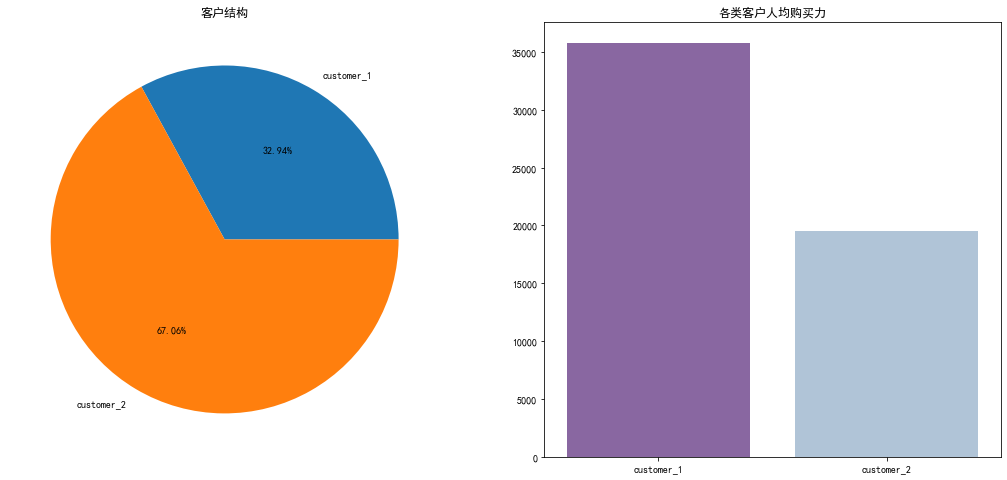

In [45]:
data_=del_data[continuous_features]
labels =  km.labels_
data_['label']=labels
data_num=data_['label'].value_counts().sort_index()
data_buy=data_.groupby('label').mean().sum(axis=1)
data_total=pd.concat([data_num,data_buy],axis=1)
data_total.rename(columns={0:'amount_per'})

f,ax=plt.subplots(1,2,figsize=(18,8))

ax[0].pie(data_num,labels=["customer_1", "customer_2"], autopct='%1.2f%%',shadow=False)

# ax[0].pie(data_num,labels=["customer_1", "customer_2",
#                            "customer_3","customer_4","customer_5", "customer_6"], autopct='%1.2f%%',shadow=False)

sns.barplot(["customer_1", "customer_2"],data_buy.values,palette="BuPu_r")
# sns.barplot(["customer_1", "customer_2","customer_3", 
#              "customer_4","customer_5", "customer_6"],data_buy.values,palette="BuPu_r")

ax[0].set_title('客户结构')

ax[1].set_title('各类客户人均购买力');

In [ ]:
'''
由上图可知，两类客户群数量差异明显，客户群1人数约为客户群2的一半；
客户群1的人均购买力较强，达到3.5万左右，客户群2的人均购买力较弱，人均2万左右；
根据购买力，我们认为客户群1为高端客户的主要来源，客户群2多为普通客户

'''

'\n由上图可知，两类客户群数量差异明显，客户群1人数约为客户群2的一半；\n客户群1的人均购买力较强，达到3.5万左右，客户群2的人均购买力较弱，人均2万左右；\n根据购买力，我们认为客户群1为高端客户的主要来源，客户群2多为普通客户\n\n'

# 客户偏好分析

In [46]:

from pandas.plotting import parallel_coordinates

customer = pd.DataFrame(centers)
customer.columns = data_new.keys()
data_median = pd.DataFrame({'2': data_new.median()}).T
customer = pd.concat([customer, data_median])
customer["category"] = ["customer_1", "customer_2",'median']
# customer["category"] = ["customer_1", "customer_2","customer_3","customer_4","customer_5", "customer_6",'median']
# customer

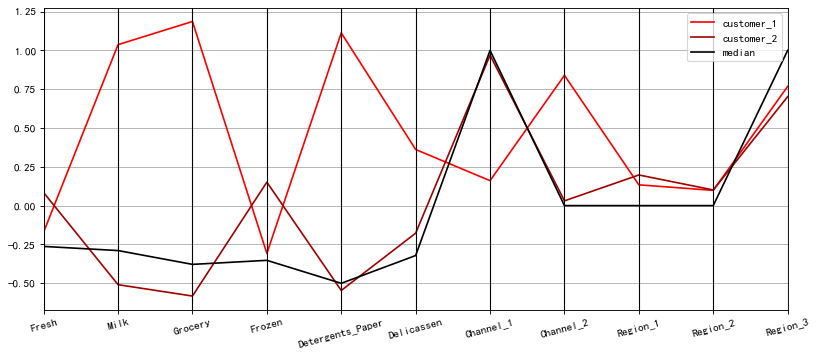

In [47]:
#绘制图像
plt.figure(figsize=(12, 5),dpi=80)
parallel_coordinates(customer[:3], "category", colormap='flag')
plt.xticks(rotation = 15)
plt.show()



In [ ]:
"""
就六种类型产品的年度支出来看, 
客户群1偏好奶制品、食品百货和清洁用品, 在新鲜和冷冻产品上关注度相对较低; 
客户群2在奶制品、食品百货和清洁用品上购买较少, 在新鲜和冷冻产品上较为偏好.


"""


# 客户来源分析

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Region           
label   customer_1 customer_2
Channel                      
1               18        221
2               94          7

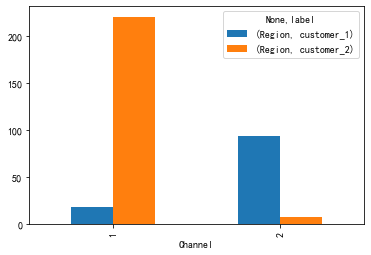

In [48]:
# 渠道分析
data_=del_data[categorical_features]
data_['label']=labels
data_123=data_[(data_.label==0)|(data_.label==1)|(data_.label==2)]

label2=data_123.label.astype('str').replace({'0':'customer_1','1':'customer_2'})
# label2=data_123.label.astype('str').replace({'0':'customer_1','1':'customer_2','2':'customer_3'})
data_123['label']=label2

data_plot=data_123.groupby(['Channel','label']).count().unstack()
data_plot.plot.bar()
data_plot

In [47]:
'''从上图中可知，客户群1有92%左右来源于渠道1，渠道2有93%为客户群2。

基于此，我们可开展精准营销活动，针对渠道1，重点推广新鲜和冷冻产品；
针对渠道2，重点推广奶制品、食品杂货和清洁用品；
鉴于客户群1为高端客户，日常需关注此渠道的运营维护；

同时，针对各渠道客群类型单一的问题，商家可进一步通过问卷调查等形式,发现可能存在的问题，
优化薄弱环节，提升服务质量。
'''


'从上图中可知，客户群1有92%左右来源于渠道1，渠道2有93%为第二类客户。\n\n基于此，我们可开展精准营销活动，针对渠道1，重点推广新鲜和冷冻产品；\n针对渠道2，重点推广奶制品、食品杂货和清洁用品；\n鉴于客户群1为高端客户，日常需关注此渠道的运营维护；\n\n同时，针对各渠道客群类型单一的问题，商家可进一步通过问卷调查等形式,发现可能存在的问题，\n优化薄弱环节，提升服务质量。\n'